<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/Implementation_of_Multiple_Recommenders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils

In [103]:
!wget https://storage.googleapis.com/pet-detect-239118/recommender/movies.csv movies.csv
!wget https://storage.googleapis.com/pet-detect-239118/recommender/ratings.csv ratings.csv

--2023-02-11 14:44:00--  https://storage.googleapis.com/pet-detect-239118/recommender/movies.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494431 (483K) [text/csv]
Saving to: ‘movies.csv.1’

movies.csv.1        100%[===================>] 482.84K  --.-KB/s    in 0.003s  

2023-02-11 14:44:01 (162 MB/s) - ‘movies.csv.1’ saved [494431/494431]

--2023-02-11 14:44:01--  http://movies.csv/
Resolving movies.csv (movies.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘movies.csv’
FINISHED --2023-02-11 14:44:01--
Total wall clock time: 1.2s
Downloaded: 1 files, 483K in 0.003s (162 MB/s)
--2023-02-11 14:44:01--  https://storage.googleapis.com/pet-detect-239118/recommender/ratings.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.12

In [104]:
dtf_products = pd.read_csv("movies.csv",header=0)
# remove missing data
# dtf_products = dtf_products[~dtf_products["genres"].isna()]

In [105]:
dtf_products["product"] = range(0,len(dtf_products))
# remove non-alphabetical characters
dtf_products["name"] = dtf_products["title"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).strip())
dtf_products["date"] = dtf_products["title"].apply(lambda x: x.split("(")[-1].replace(")","").strip() if "(" in x else np.nan)

In [106]:
dtf_products['date'].value_counts()
# find a abnormal value 2006-2007

2002         311
2006         295
2001         294
2007         284
2000         283
            ... 
1921           1
1902           1
1915           1
1903           1
2006–2007      1
Name: date, Length: 107, dtype: int64

In [107]:
# replace the value '2006-2007' with '2006'
dtf_products['date'].replace(to_replace=['2006–2007'], value='2006', inplace=True)
dtf_products["date"] = dtf_products["date"].fillna(9999)  # fill the missing data with '9999'
dtf_products["date"] = dtf_products["date"].apply(lambda x: float(x)) # convert the column from string to integer
dtf_products["old"] = dtf_products["date"].apply(lambda x: 1 if x < 2000 else 0) # the movie earlier than 2000 is considered old movie

In [108]:
dtf_products.isnull().sum()
# no missing data now

movieId    0
title      0
genres     0
product    0
name       0
date       0
old        0
dtype: int64

In [109]:
dtf_products

,movieId,title,genres,product,name,date,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,1
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9737,Black Butler: Book of the Atlantic,2017.0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9738,No Game No Life: Zero,2017.0,0
9739,193585,Flint (2017),Drama,9739,Flint,2017.0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9740,Bungo Stray Dogs: Dead Apple,2018.0,0


In [110]:
dtf_users = pd.read_csv("ratings.csv",header=0)
# remove missing data
# dtf_users = dtf_users[~dtf_users['rating'].isna()]

In [111]:
# re-number user from 0
dtf_users["user"] = dtf_users["userId"].apply(lambda x: x-1)
# reformat time stamp
dtf_users["timestamp"] = dtf_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))
# if the time between 6AM and 8PM, label the record as daytime with '1'
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)
# if the day is Friday or Saturnday, label the record as weekend with '1'
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)

In [112]:
dtf_users

,userId,movieId,rating,timestamp,user,daytime,weekend
0,1,1,4.0,2000-07-30 18:45:03,0,1,1
1,1,3,4.0,2000-07-30 18:20:47,0,1,1
2,1,6,4.0,2000-07-30 18:37:04,0,1,1
3,1,47,5.0,2000-07-30 19:03:35,0,1,1
4,1,50,5.0,2000-07-30 18:48:51,0,1,1
...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,609,0,0
100832,610,168248,5.0,2017-05-03 22:21:31,609,0,0
100833,610,168250,5.0,2017-05-08 19:50:47,609,1,0
100834,610,168252,5.0,2017-05-03 21:19:12,609,0,0


In [113]:
# left join 
dtf_users = dtf_users.merge(dtf_products[["movieId","product"]], how="left")

In [114]:
dtf_users

,userId,movieId,rating,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 18:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 18:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 18:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 19:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 18:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,609,0,0,9434
100832,610,168248,5.0,2017-05-03 22:21:31,609,0,0,9461
100833,610,168250,5.0,2017-05-08 19:50:47,609,1,0,9462
100834,610,168252,5.0,2017-05-03 21:19:12,609,0,0,9463


In [115]:
dtf_users = dtf_users.rename(columns={"rating":"y"})

In [116]:
dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 18:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 18:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 18:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 19:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 18:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,609,0,0,9434
100832,610,168248,5.0,2017-05-03 22:21:31,609,0,0,9461
100833,610,168250,5.0,2017-05-08 19:50:47,609,1,0,9462
100834,610,168252,5.0,2017-05-03 21:19:12,609,0,0,9463


In [117]:
# Clean
dtf_products = dtf_products[["product","name","old","genres"]].set_index("product")
dtf_users = dtf_users[["user","product","daytime","weekend","y"]]

In [118]:
dtf_products

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy
...,...,...,...
9737,Black Butler: Book of the Atlantic,0,Action|Animation|Comedy|Fantasy
9738,No Game No Life: Zero,0,Animation|Comedy|Fantasy
9739,Flint,0,Drama


In [119]:
dtf_users.head()

,user,product,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


In [120]:
# use the context table to save the features
dtf_context = dtf_users[["user","product","daytime","weekend"]]

In [121]:
dtf_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [122]:
dtf_users = dtf_users[["user","product","y"]]
dtf_users

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0
...,...,...,...
100831,609,9434,4.0
100832,609,9461,5.0
100833,609,9462,5.0
100834,609,9463,5.0


split the genres into single terms

In [123]:
# split the terms
tags = [i.split("|") for i in dtf_products["genres"].unique()]
columns = list(set([i for lst in tags for i in lst]))

In [124]:
columns

['Thriller',
 '(no genres listed)',
 'Mystery',
 'War',
 'Children',
 'Fantasy',
 'Drama',
 'IMAX',
 'Documentary',
 'Comedy',
 'Crime',
 'Romance',
 'Animation',
 'Film-Noir',
 'Horror',
 'Action',
 'Sci-Fi',
 'Musical',
 'Western',
 'Adventure']

In [125]:
# remove the abnormal 'no genres listed'
columns.remove('(no genres listed)')
columns

['Thriller',
 'Mystery',
 'War',
 'Children',
 'Fantasy',
 'Drama',
 'IMAX',
 'Documentary',
 'Comedy',
 'Crime',
 'Romance',
 'Animation',
 'Film-Noir',
 'Horror',
 'Action',
 'Sci-Fi',
 'Musical',
 'Western',
 'Adventure']

In [126]:
# add each genre as new column
for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)
dtf_products.head()

,name,old,genres,Thriller,Mystery,War,Children,Fantasy,Drama,IMAX,...,Crime,Romance,Animation,Film-Noir,Horror,Action,Sci-Fi,Musical,Western,Adventure
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,Jumanji,1,Adventure|Children|Fantasy,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,1,Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


show the product (movie)- feature (genre) interaction

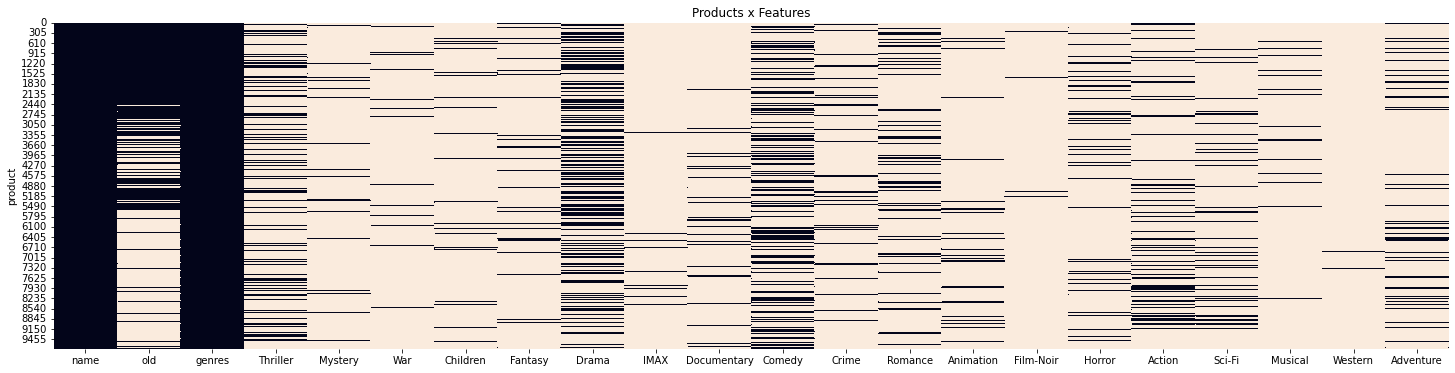

In [127]:
fig, ax = plt.subplots(figsize=(25,6))
sns.heatmap(dtf_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

show the product (movie) viewed by each user

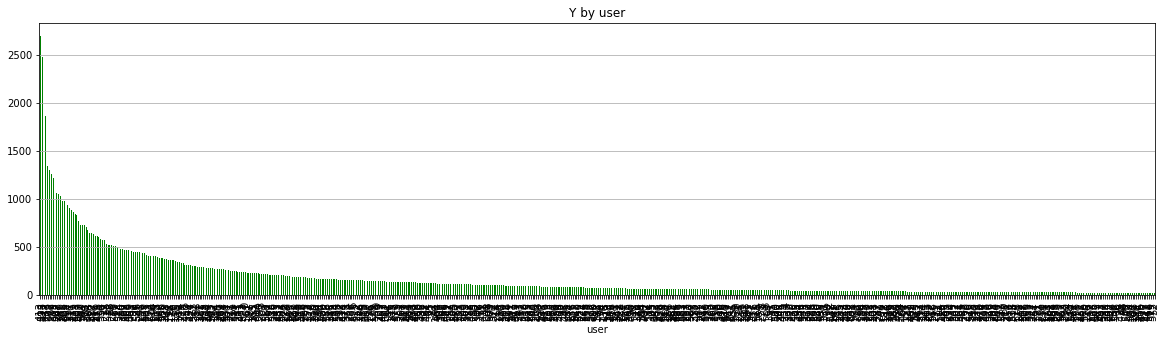

In [128]:
dtf_users.groupby("user").count()["product"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(20,5)).grid(axis='y')

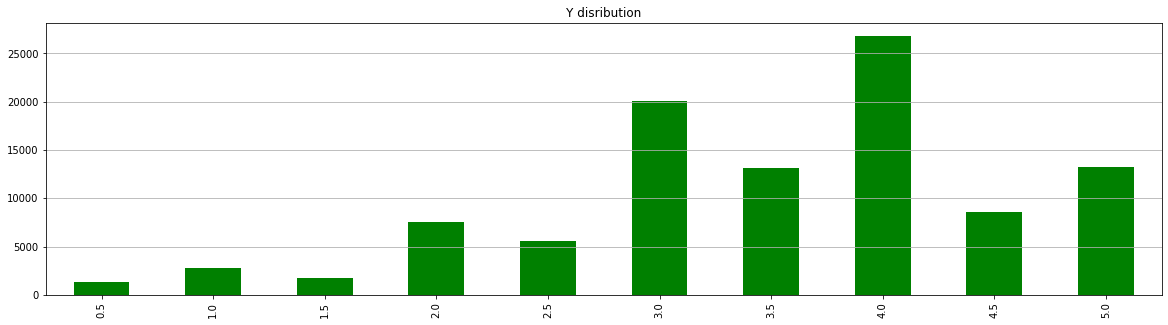

In [129]:
dtf_users["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y disribution", 
                                                figsize=(20,5)).grid(axis='y')
plt.show()

Make the Users - Products interaction matrix

In [130]:
tmp = dtf_users.copy()
dtf_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(dtf_products.index) - set(dtf_users.columns))
# add the missing products to the user table columns to match the users table and products table dimension
for col in missing_cols:
    dtf_users[col] = np.nan
dtf_users = dtf_users[sorted(dtf_users.columns)]
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


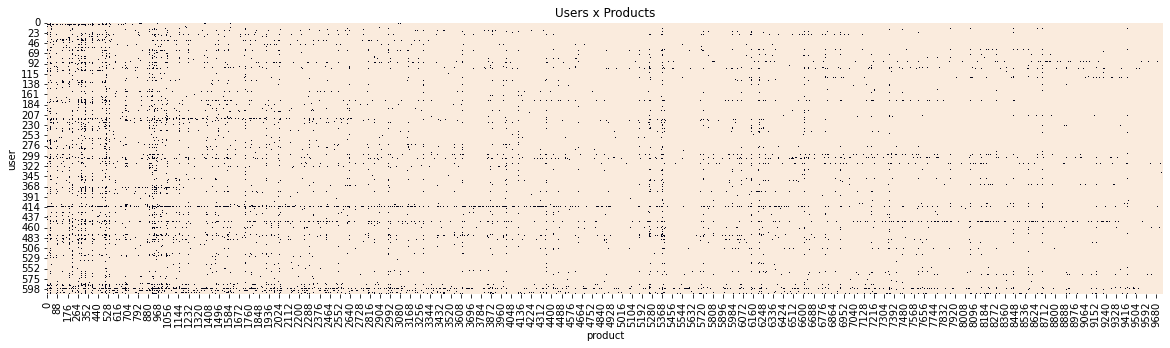

In [131]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(dtf_users.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Products")
plt.show()

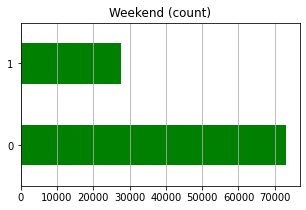

In [132]:
dtf_context["weekend"].value_counts().plot(kind="barh", color="green", title="Weekend (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

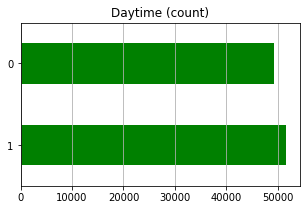

In [133]:
dtf_context["daytime"].value_counts().plot(kind="barh", color="green", title="Daytime (count)", 
                                         figsize=(5,3)).grid(axis='x')
plt.show()

In [134]:
# normalize the rating score
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values), columns=dtf_users.columns, index=dtf_users.index)

In [135]:
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Split 80% data for training and 20% for test

In [136]:
split = int(0.8*dtf_users.shape[1])
split

7793

In [137]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 94054


product,0,1,2,3,4,5,6,7,8,9,...,7783,7784,7785,7786,7787,7788,7789,7790,7791,7792
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 6782


product,7793,7794,7795,7796,7797,7798,7799,7800,7801,7802,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Baseline filter (Content-Based)

In [139]:
# Select the rows where user - i=1
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7793,NaN
7794,NaN
7795,NaN
7796,NaN
7797,NaN


In [140]:
# add all products in the test split to train set but leaving the rating empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.tail()

,y
product,
9737,NaN
9738,NaN
9739,NaN
9740,NaN
9741,NaN


In [141]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)
print(f'the second user rates {usr.shape[1]} products with {prd.shape[1]} features')

Users (1, 9742)  x  Products (9742, 20)
the second user rates 9742 products with 20 features


use the numpy to build the interaction table

In [142]:
## usr_ft(users,fatures) = usr(users,products) x prd(products,features)
# user-product interaction table - 1 user X 20 features 
usr_ft = np.dot(usr, prd)
usr_ft.shape

(1, 20)

In [143]:
# normalize
weights = usr_ft / usr_ft.sum()
weights.shape

(1, 20)

In [144]:
# predicted rating(users,products) = weights(users,fatures) x prd.T(features,products)
# rate the whole 9742 products given the second user
pred = np.dot(weights, prd.T)
pred.shape

(1, 9742)

In [145]:
test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
270,8063,0.812500,0.367409
512,8305,1.000000,0.446949
583,8376,0.777778,0.071390
673,8466,0.875000,0.211218
716,8509,0.500000,0.467547
757,8550,0.833333,0.348377
888,8681,1.000000,0.328201
1035,8828,0.500000,0.030355


Use tensorflow to do content-based filtering

In [146]:
import tensorflow as tf

# usr_ft(users,fatures) = usr(users,products) x prd(products,features)
usr_ft = tf.matmul(usr, prd)
usr_ft.shape

TensorShape([1, 20])

In [147]:
weights = usr_ft / tf.reduce_sum(usr_ft, axis=1, keepdims=True)
# rating all products given the user
# rating(users,products) = weights(users,fatures) x prd.T(features,products)
pred = tf.matmul(weights, prd.T)
pred

<tf.Tensor: shape=(1, 9742), dtype=float64, numpy=
array([[0.18528036, 0.08670776, 0.16940033, ..., 0.21121841, 0.1561904 ,
        0.15042862]])>

In [148]:
test = dtf_test.iloc[i].to_frame(name="y")
test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test

,product,y,yhat
0,7793,NaN,0.211218
1,7794,NaN,0.275361
2,7795,NaN,0.098573
3,7796,NaN,0.330389
4,7797,NaN,0.211218
...,...,...,...
1944,9737,NaN,0.254763
1945,9738,NaN,0.098573
1946,9739,NaN,0.211218
1947,9740,NaN,0.156190


In [149]:
test = test[~test["y"].isna()]
test

,product,y,yhat
270,8063,0.812500,0.367409
512,8305,1.000000,0.446949
583,8376,0.777778,0.071390
673,8466,0.875000,0.211218
716,8509,0.500000,0.467547
757,8550,0.833333,0.348377
888,8681,1.000000,0.328201
1035,8828,0.500000,0.030355


Function to compute the reciprocal rank

In [150]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [151]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print('----The true top 5 products----')
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print('----The predicted top 5 products----')
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
----The true top 5 products----
y_test: [8305 8681 8466 8550 8063]
----The predicted top 5 products----
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 20.0%
mrr: 0.26


In [152]:
test.merge(dtf_products[["name","old","genres"]], left_on="product", right_index=True).sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
716,8509,0.500000,0.467547,The Drop,0,Crime|Drama|Thriller
512,8305,1.000000,0.446949,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
270,8063,0.812500,0.367409,Django Unchained,0,Action|Drama|Western
757,8550,0.833333,0.348377,Ex Machina,0,Drama|Sci-Fi|Thriller
888,8681,1.000000,0.328201,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
673,8466,0.875000,0.211218,Whiplash,0,Drama
583,8376,0.777778,0.071390,Interstellar,0,Sci-Fi|IMAX
1035,8828,0.500000,0.030355,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


Collaborative Filtering Model -  similar users like similar products <p>


*   Memory-based: find similar users with correlation metrics, such as cosine similarity, and clustering
*   Model-based: predict how users would rate a certain product by applying supervised machine learning and matrix factorization. Matrix factorization splits the large Users-Products matrix into 2 smaller factors representing the Users matrix and the Products matrix



In [153]:
# reshape the interaction table to a normal dataframe
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [154]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000


In [155]:
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
print(f'users={usr}, products={prd}')

users=610, products=9742


Building an embedding model (NN)

In [156]:
embeddings_size = 50
# the embedding layers for users
# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_input = layers.Input(name="xusers_in", shape=(1,))
xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_input) # embedding - input_dim=610, output_dim=50
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

In [157]:
# the embedding layers for products
# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_input = layers.Input(name="xproducts_in", shape=(1,))
xproducts_emb = layers.Embedding(name="xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_input) # embedding - input_dim=9742, output_dim=50
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

In [158]:
# compute the Dot Product (,1) values[-1,1]
xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xproducts])

In [159]:
# predPredict ratings (,1)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)

In [160]:
# Compile
model = models.Model(inputs=[xusers_input,xproducts_input], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 xusers_emb (Embedding)         (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 xproducts_emb (Embedding)      (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                                             

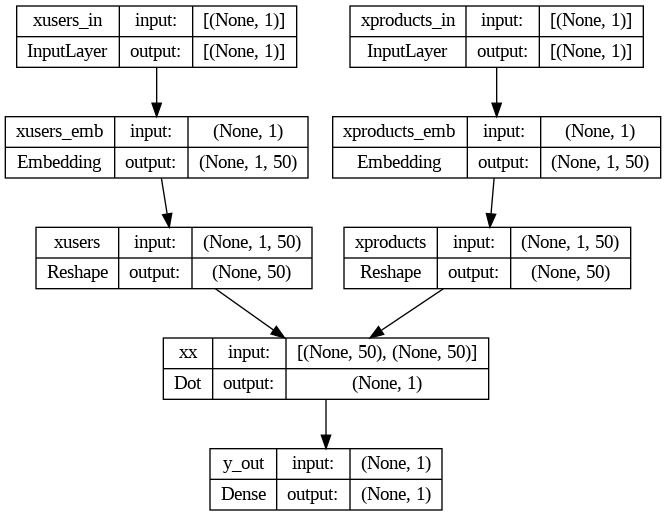

In [161]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [162]:
'''
Plot loss and metrics of training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [163]:
train

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000
...,...,...,...
94049,609,7769,0.750000
94050,609,7770,0.785714
94051,609,7774,1.000000
94052,609,7776,0.888889


In [164]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model

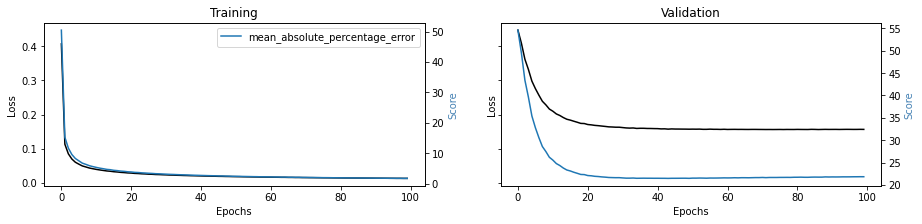

In [165]:
utils_plot_keras_training(training)

In [166]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

212/212 [==============================] - 0s 2ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.742271
1,1,8305,1.000000,0.932648
2,1,8376,0.777778,0.908941
3,1,8466,0.875000,0.760505
4,1,8509,0.500000,0.822015
...,...,...,...,...
6777,609,9434,0.937500,0.902345
6778,609,9461,1.000000,0.704014
6779,609,9462,1.000000,0.810524
6780,609,9463,1.000000,0.561467


In [167]:
# model evaluate
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.25%


In [168]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8305 8376 8828 8550 8509]
true positive: 2 (40.0%)
accuracy: 40.0%
mrr: 0.25


In [169]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
1,1,8305,1.000000,0.932648,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
2,1,8376,0.777778,0.908941,Interstellar,0,Sci-Fi|IMAX
7,1,8828,0.500000,0.869847,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
5,1,8550,0.833333,0.865805,Ex Machina,0,Drama|Sci-Fi|Thriller
4,1,8509,0.500000,0.822015,The Drop,0,Crime|Drama|Thriller
3,1,8466,0.875000,0.760505,Whiplash,0,Drama
0,1,8063,0.812500,0.742271,Django Unchained,0,Action|Drama|Western
6,1,8681,1.000000,0.716644,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller


Neural Collaborative Filtering - combines non-linearity from Neural Networks and Matrix Factorization

In [170]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
print(f'users={usr}, products={prd}')

users=610, products=9742


In [171]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [172]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000


DNN+Collaborative Filtering model

In [173]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

Matrix Factorization module

In [174]:
# user embedding
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)

# product embedding
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)

# combine the two embedding by dot-product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

DNN module

In [175]:
# user embedding
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)

# product embedding
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)

# concatenate the two embedding network
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

Merge the Matrix Factorization module and the DNN module

In [176]:
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

Model combine

In [177]:
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                                      

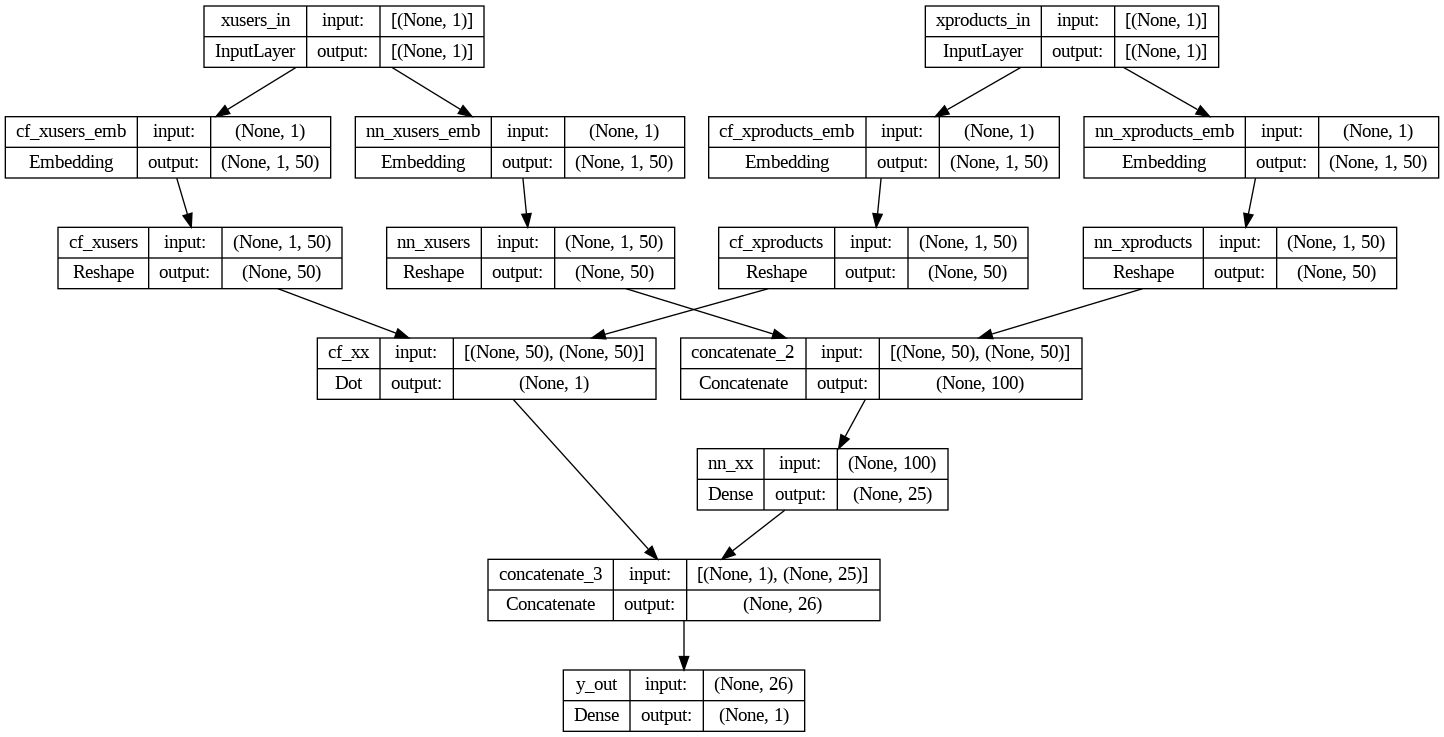

In [178]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Train and test the DNN + Matrix Factorization model

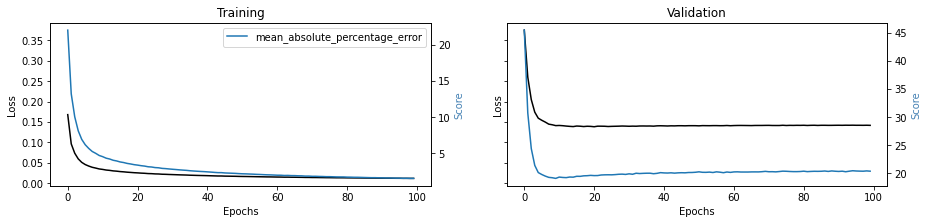

In [179]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [180]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

212/212 [==============================] - 1s 2ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.765141
1,1,8305,1.000000,0.888155
2,1,8376,0.777778,0.797627
3,1,8466,0.875000,0.864820
4,1,8509,0.500000,0.803308
...,...,...,...,...
6777,609,9434,0.937500,0.612119
6778,609,9461,1.000000,0.793923
6779,609,9462,1.000000,0.680227
6780,609,9463,1.000000,0.781604


In [181]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.22%


In [182]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8681 8305 8466 8509 8828]
true positive: 3 (60.0%)
accuracy: 20.0%
mrr: 0.37


In [183]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
6,1,8681,1.000000,0.967874,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
1,1,8305,1.000000,0.888155,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
3,1,8466,0.875000,0.864820,Whiplash,0,Drama
4,1,8509,0.500000,0.803308,The Drop,0,Crime|Drama|Thriller
7,1,8828,0.500000,0.801847,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
2,1,8376,0.777778,0.797627,Interstellar,0,Sci-Fi|IMAX
0,1,8063,0.812500,0.765141,Django Unchained,0,Action|Drama|Western
5,1,8550,0.833333,0.665251,Ex Machina,0,Drama|Sci-Fi|Thriller


# Hybrid Model
combine all the useful features from users and products.


*   Product features - tags and descriptions of the items (i.e. movie genres), mostly used in the Content-Based methods.
*  User profile - descriptive information about users can be demographics (i.e. gender and age) or behavioral (i.e. preferences, average time on screen, most frequent time of usage), mostly used for Knowledge-Based recommendations.

*   Context — additional information regarding the situation around the rating (i.e. when, where, search history), often included in Knowledge-Based recommendations 
*   Target variable — ratings can be explicit (i.e. the user leaves feedback) or implicit (i.e. assuming positive feedback if the user watches the whole movie)





In [184]:
features = dtf_products.drop(["genres","name"], axis=1).columns
print(features)
context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

Index(['old', 'Thriller', 'Mystery', 'War', 'Children', 'Fantasy', 'Drama',
       'IMAX', 'Documentary', 'Comedy', 'Crime', 'Romance', 'Animation',
       'Film-Noir', 'Horror', 'Action', 'Sci-Fi', 'Musical', 'Western',
       'Adventure'],
      dtype='object')
Index(['daytime', 'weekend'], dtype='object')


In [188]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

,user,product,y,old,Thriller,Mystery,War,Children,Fantasy,Drama,...,Animation,Film-Noir,Horror,Action,Sci-Fi,Musical,Western,Adventure,daytime,weekend
0,0,0,0.888889,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,1,1,1
1,0,2,0.888889,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,5,0.875000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
3,0,43,1.000000,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,46,1.000000,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [189]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_products.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test[context] = 0 #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

,user,product,y,old,Thriller,Mystery,War,Children,Fantasy,Drama,...,Animation,Film-Noir,Horror,Action,Sci-Fi,Musical,Western,Adventure,daytime,weekend
0,1,8063,0.812500,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1,1,8305,1.000000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,8376,0.777778,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,8466,0.875000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,8509,0.500000,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [190]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)
print(f'features={feat}, context={ctx}')

features=20, context=2


Collaborative Filtering

In [191]:
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization Module
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)

cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)

# combine
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network Module
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)

nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)

## concatenate the two modules
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

Content Based Filtering

In [192]:
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

Knowledge Based Filtering

In [193]:
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

Merge the Factorization Module + NN Module + Content-based Module + Knowledge-based Module

In [195]:
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

In [196]:
# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        30500       ['xusers_in[0][0]']              
                                                                                                  
 nn_xproducts_emb (Embedding)   (None, 1, 50)        487100      ['xproducts_in[0][0]']           
                                                                                       

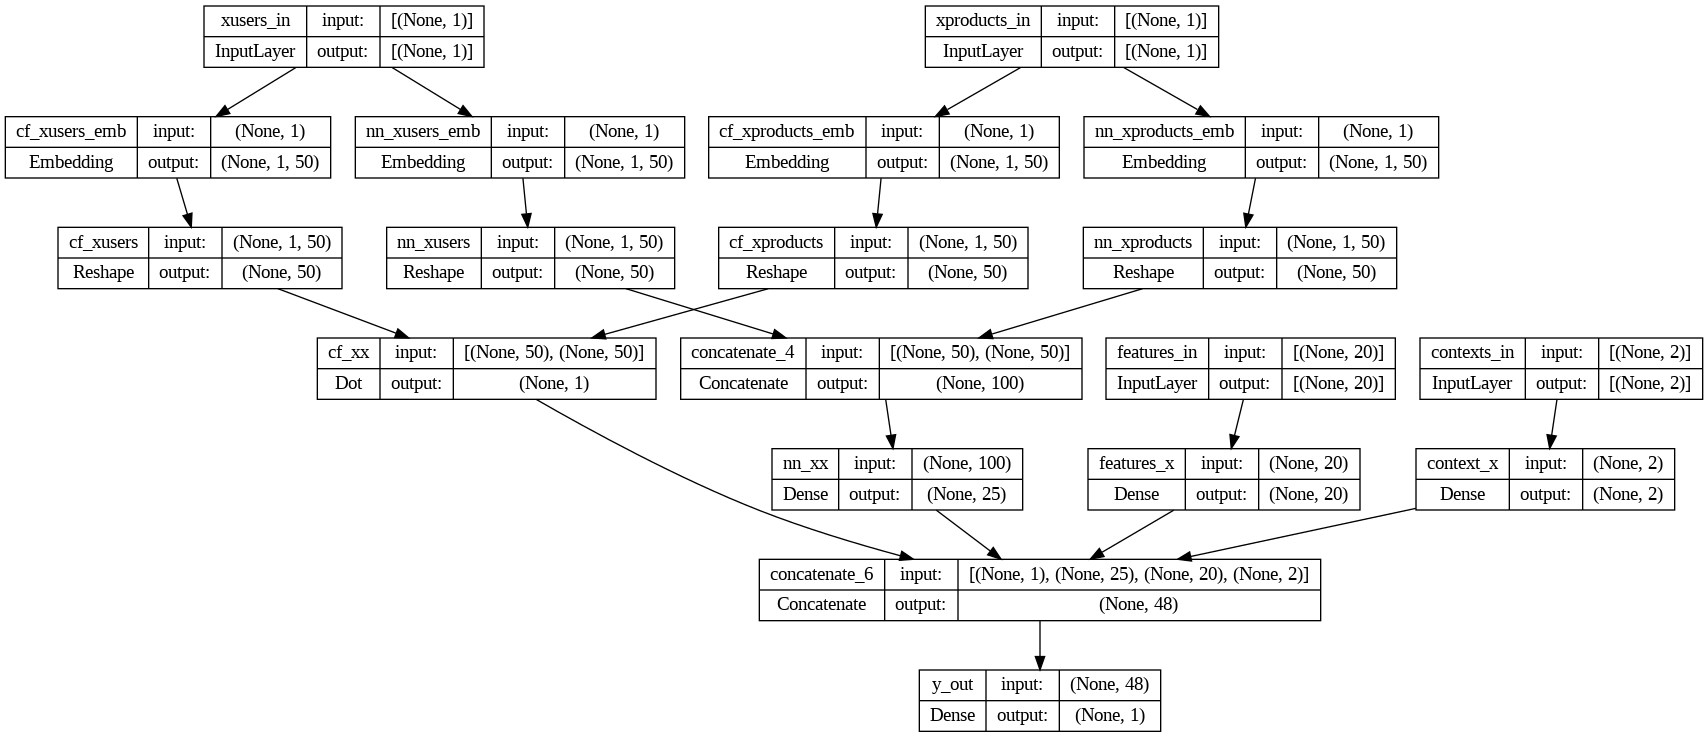

In [197]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Train, Test, Evaluate the Hybrid model

In [198]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

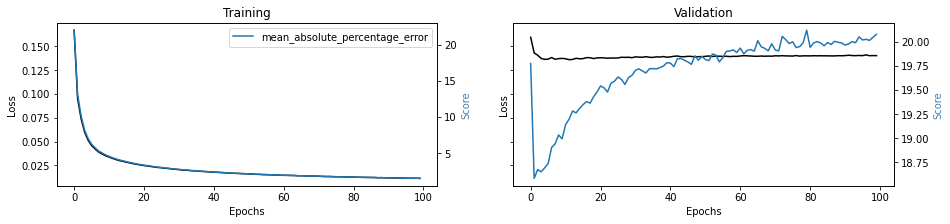

In [199]:
model = training.model
utils_plot_keras_training(training)

In [208]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test[['user','product', 'y', 'yhat']]

212/212 [==============================] - 1s 3ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.903250
1,1,8305,1.000000,0.817579
2,1,8376,0.777778,0.875882
3,1,8466,0.875000,0.775708
4,1,8509,0.500000,0.993713
...,...,...,...,...
6777,609,9434,0.937500,0.651241
6778,609,9461,1.000000,0.908948
6779,609,9462,1.000000,0.667500
6780,609,9463,1.000000,0.764805


In [209]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Error (Σ|y-pred|/n): 0
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.22%


In [210]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8509 8063 8376 8828 8305]
true positive: 2 (40.0%)
accuracy: 0.0%
mrr: 0.14
